In memory of Dr.Jian Sun, the author of ResNet. May Dr.Sun rest in peace.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

This is resnet architecture with bottle neck, designed in resnet.

In this architecture, there are 2 main designs:

skip connection, which makes lower network to have closer connection with higher network
bottle neck, which reduces computation without accuracy loss by using more 1*1 kernel

In [2]:
class BottleNeck(tf.keras.layers.Layer):
    def __init__(self, filter_num, stride=1):
        super(BottleNeck, self).__init__()
        self.conv1 = layers.Conv2D(filters=filter_num,
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding='same')
        self.bn1 =layers.BatchNormalization()
        self.conv2 = layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            padding='same')
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv2D(filters=filter_num * 4,
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding='same') # bottleneck
        self.bn3 = layers.BatchNormalization()

        self.downsample = models.Sequential()
        self.downsample.add(layers.Conv2D(filters=filter_num * 4,
                                                   kernel_size=(1, 1),
                                                   strides=stride))
        self.downsample.add(layers.BatchNormalization())

    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv3(x)
        x = self.bn3(x, training=training)

        output = tf.nn.relu(layers.add([residual, x])) # residual unit

        return output

Following design in resnet, use 2 resnet block in sequence

In [3]:
def make_bottleneck_layer(filter_num, blocks, stride=1):
    res_block = models.Sequential()
    res_block.add(BottleNeck(filter_num, stride=stride))

    for _ in range(1, blocks):
        res_block.add(BottleNeck(filter_num, stride=1))

    return res_block

To make the network lighter, choose resnet18 instead of regular resnet50 or larger

In [4]:
class ResNet18(tf.keras.Model):
    def __init__(self, layer_params):
        super(ResNet18, self).__init__()

        self.conv1 = layers.Conv2D(filters=64,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same")
        self.bn1 = layers.BatchNormalization()
        self.pool1 = layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")

        self.layer1 = make_bottleneck_layer(filter_num=64,
                                             blocks=layer_params[0])
        self.layer2 = make_bottleneck_layer(filter_num=128,
                                             blocks=layer_params[1],
                                             stride=2)
        self.layer3 = make_bottleneck_layer(filter_num=256,
                                             blocks=layer_params[2],
                                             stride=2)
        self.layer4 = make_bottleneck_layer(filter_num=512,
                                             blocks=layer_params[3],
                                             stride=2)

        self.avgpool = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(units=10, activation=tf.keras.activations.softmax)

    def call(self, inputs, training=None, mask=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)
        x = self.avgpool(x)
        output = self.fc(x)

        return output

select fashion mnist as my dataset

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() # load data
x_train = np.expand_dims(x_train, -1).astype(np.float16)
x_test = np.expand_dims(x_test, -1).astype(np.float16)
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

Show dataset in matplotlib to verify images and labels

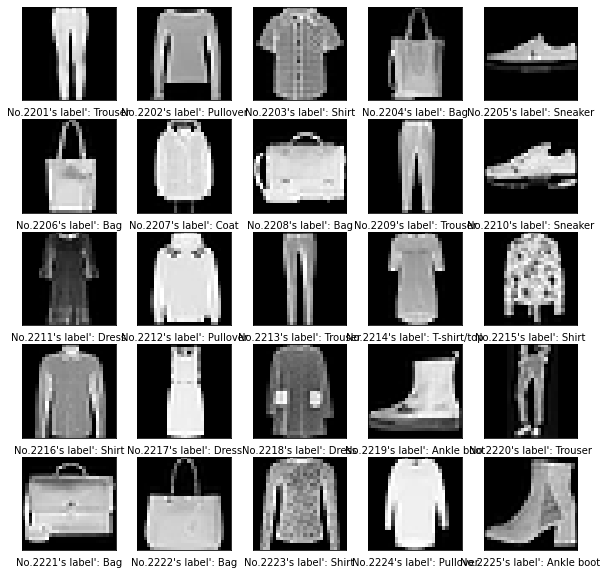

In [9]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
# Note: for train dataset(x_train, y_train), image_index should between 0~59975
# for test dataset(x_test, y_test), image_index should be between 0~9975
def show_image(x_dataset, y_dataset, image_index):
    plt.figure(figsize=(10,10))
    for idx in range(25):
        plt.subplot(5,5,idx+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_dataset[image_index+idx][:, :, 0].astype(np.uint8), cmap='gray')

        plt.xlabel("No.{}'s label': {}".format(image_index+idx+1, class_names[y_dataset[image_index+idx]]))
    plt.show()
    plt.close()
show_image(x_train, y_train, 2200)

train my model

In [10]:
model = ResNet18(layer_params=[2, 2, 2, 2])
model.compile(optimizer='adam', # sgd
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # loss function
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=30, 
                    validation_data=(x_test, y_test))

Epoch 1/30
1875/1875 [==============================] - 108s 53ms/step - loss: 0.5887 - accuracy: 0.8031 - val_loss: 0.3883 - val_accuracy: 0.8646
Epoch 2/30
1875/1875 [==============================] - 99s 53ms/step - loss: 0.4054 - accuracy: 0.8575 - val_loss: 0.8089 - val_accuracy: 0.8001
Epoch 3/30
1875/1875 [==============================] - 99s 53ms/step - loss: 0.3720 - accuracy: 0.8700 - val_loss: 0.4034 - val_accuracy: 0.8637
Epoch 4/30
1875/1875 [==============================] - 99s 53ms/step - loss: 0.3434 - accuracy: 0.8791 - val_loss: 0.3437 - val_accuracy: 0.8727
Epoch 5/30
1875/1875 [==============================] - 99s 53ms/step - loss: 0.3049 - accuracy: 0.8913 - val_loss: 0.2965 - val_accuracy: 0.8953
Epoch 6/30
1875/1875 [==============================] - 100s 53ms/step - loss: 0.2735 - accuracy: 0.9007 - val_loss: 0.3147 - val_accuracy: 0.8828
Epoch 7/30
1875/1875 [==============================] - 100s 53ms/step - loss: 0.2791 - accuracy: 0.9005 - val_loss: 0.281

a graph of accuracy

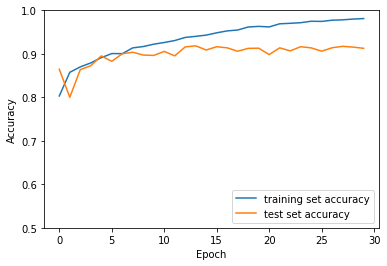

In [11]:
plt.plot(history.history['accuracy'], label='training set accuracy')
plt.plot(history.history['val_accuracy'], label = 'test set accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [12]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print("Test accuracy after final epoch is ", test_acc*100)

313/313 - 5s - loss: 0.3435 - accuracy: 0.9127
Test accuracy after final epoch is  91.26999974250793
